In [3]:
!pip install hmmlearn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from google.colab import drive, files

In [4]:
drive.mount('/content/drive', force_remount=True)
# Change the folder path to wherever you are keeping the data and the next block will load everything in for you
# Frank path: '/content/drive/MyDrive/Classes/7 Fall 2025/DS 340/DS 340 Project/data'
# Jesse path: '/content/drive/MyDrive/340 Data'

folder_path = '/content/drive/MyDrive/340 Data'

Mounted at /content/drive


## Load data

In [5]:
def load_and_transform_data(folder_path):
  dfs = {}
  for filename in os.listdir(folder_path):
      if filename.endswith('.csv'):
          file_path = os.path.join(folder_path, filename)
          df_name = filename.replace('.csv', '')
          print(f'Reading file: {df_name}')
          try:
              df = pd.read_csv(file_path)
              df['observation_date'] = pd.to_datetime(df['observation_date'], errors='coerce')
              df = df.set_index('observation_date')

              value_col = [col for col in df.columns if col != 'observation_date']
              if value_col:
                  df[value_col[0]] = pd.to_numeric(df[value_col[0]], errors='coerce')
                  df = df.rename(columns={value_col[0]: df_name})
              else:
                  print(f"Warning: No suitable value column found in {filename}. Skipping.")
                  continue

              dfs[df_name] = df
          except Exception as e:
              print(f"Error reading {filename}: {e}")

  print(f"Loaded {len(dfs)} DataFrames from {folder_path}.")
  print("Keys in 'dfs' dictionary:", dfs.keys())

  combined_df = pd.concat(dfs.values(), axis=1)

  desired_order_list = ['HIGH_YIELD', 'CORPORATE', 'AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC_LOWER']
  return combined_df[desired_order_list]

combined_df = load_and_transform_data(folder_path)

Reading file: HIGH_YIELD
Reading file: CORPORATE
Reading file: AAA
Reading file: AA
Reading file: A
Reading file: BBB
Reading file: BB
Reading file: B
Reading file: CCC_LOWER
Loaded 9 DataFrames from /content/drive/MyDrive/340 Data.
Keys in 'dfs' dictionary: dict_keys(['HIGH_YIELD', 'CORPORATE', 'AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC_LOWER'])


Below is the data without any additional modifications.

In [6]:
combined_df

,HIGH_YIELD,CORPORATE,AAA,AA,A,BBB,BB,B,CCC_LOWER
observation_date,,,,,,,,,
1996-12-31,3.13,0.60,0.30,0.42,0.57,0.83,1.95,3.61,7.38
1997-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-02,3.06,0.60,0.26,0.42,0.58,0.83,1.92,3.51,7.28
1997-01-03,3.09,0.61,0.31,0.43,0.57,0.83,1.94,3.54,7.37
1997-01-06,3.10,0.61,0.26,0.43,0.58,0.85,1.94,3.55,7.36
...,...,...,...,...,...,...,...,...,...
2025-11-13,3.09,0.84,0.36,0.49,0.69,1.06,1.89,3.23,9.07
2025-11-14,3.07,0.83,0.36,0.48,0.68,1.06,1.85,3.25,9.02
2025-11-17,3.13,0.84,0.36,0.49,0.69,1.06,1.90,3.32,9.08


## Preprocessing

We will use the daily difference in each of these sets (and drop nulls) as these differences give a stronger indiciation to the model of how the magnitude of these spreads changes by day, rather than a complete magnitude of the spread. The data is already clean, so this is the only main thing we need to do in our preprocessing besides the PCA

In [7]:
df_deltas = combined_df.diff().dropna()
df_deltas

,HIGH_YIELD,CORPORATE,AAA,AA,A,BBB,BB,B,CCC_LOWER
observation_date,,,,,,,,,
1997-01-03,0.03,0.01,0.05,0.01,-0.01,0.00,0.02,0.03,0.09
1997-01-06,0.01,0.00,-0.05,0.00,0.01,0.02,0.00,0.01,-0.01
1997-01-07,0.00,0.00,0.02,0.00,0.00,-0.01,-0.01,0.01,0.00
1997-01-08,-0.03,-0.01,0.00,-0.01,-0.01,-0.01,-0.02,-0.03,-0.02
1997-01-09,0.06,0.02,0.05,0.03,0.02,0.02,0.05,0.05,0.13
...,...,...,...,...,...,...,...,...,...
2025-11-13,0.07,0.01,0.00,0.00,0.01,0.01,0.07,0.08,0.12
2025-11-14,-0.02,-0.01,0.00,-0.01,-0.01,0.00,-0.04,0.02,-0.05
2025-11-17,0.06,0.01,0.00,0.01,0.01,0.00,0.05,0.07,0.06


### KL Expansion (PCA) and Reconstruction

The following function takes in a "training" range, i.e., where we want to do PCA, and takes in a param for how much variance we want to explain in our PCs. We recenter the data, find the covariance matrix, and do the SVD to find the eigvals and eigvecs. Then we sort these eigvals descending and choose how many eigvals/eigvecs to use based on the amount of variance we want to explain (the sum of all eigenvalues will add to 1, i.e., the total variance of the dataset).

With these eigenvectors we can get the new feature vectors and project our centered data onto this low dim. basis. Finally, we reconstruct the centered data by taking the centered data and putting it back onto the original space. We add back the mean to get back the final reconstructed data.

To get information on anomaly points, we calculate the residuals (reconstruction error) between our original data and the reconstructed data. We also use the discarded variance (that which was not captured by our eigenvectors) and use it as a normalization factor for the norms of our residual data. These values are our final KL scores, where higher scores mean higher chance of anomaly.

In [8]:
import numpy as np
import pandas as pd

def kl_expansion_and_reconstruct(df_train: pd.DataFrame,
                                 train_start,
                                 train_end,
                                 target_var_explained):
    # get range
    df_train = df_train.loc[train_start:train_end].copy()
    X = df_train.values

    # recenter
    mu = X.mean(axis=0)
    X_centered = X - mu

    # compute cov matrix
    cov_matrix = np.cov(X_centered, rowvar=False)

    # decomposition
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # sort largest to smallest
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # find num components `m` based on hyperparam
    cumvar = np.cumsum(eigvals)
    total_var = cumvar[-1]
    var_ratio = cumvar / total_var
    m = np.searchsorted(var_ratio, target_var_explained) + 1
    m = min(m, eigvals.shape[0])

    print(f"Chosen m: {m}/{len(eigvals)} (Explained Var: {var_ratio[m-1]:.4f})")

    # gather normalization factor via discarded variance
    discarded_var = eigvals[m:].sum() if m < len(eigvals) else 0.0
    normalization_factor = np.sqrt(discarded_var + 1e-9)

    # projection
    Phi_m = eigvecs[:, :m]

    # (T, N) @ (N, m) -> (T, m)
    Z_projected = X_centered @ Phi_m

    # (T, m) @ (m, N) -> (T, N)
    reconstruction = Z_projected @ Phi_m.T
    v_hat = mu + reconstruction

    # find residuals
    residuals = X - v_hat
    residual_norms = np.linalg.norm(residuals, axis=1)

    # normalize for final scores
    scores = residual_norms / normalization_factor

    df_kl = pd.DataFrame(
      residuals,
      index=df_train.index,
      columns=[f"residual_{col}" for col in df_train.columns]
    )
    df_kl["kl_score"] = scores

    return df_kl, residuals, scores, eigvals, eigvecs, mu, var_ratio, m

This function is almost the same exact process, but takes in the eigenvectors and eigenvalues from the previous function to project the rest of the data onto the space, and reconstruct it to find the errors.

In [9]:
def apply_kl_transform(df_full: pd.DataFrame,
                       mu_calm: np.ndarray,
                       eigvecs_calm: np.ndarray,
                       m_calm: int,
                       eigvals_calm: np.ndarray):
    X_full = df_full.values
    X_centered_full = X_full - mu_calm

    # projection
    Phi_m_calm = eigvecs_calm[:, :m_calm]
    Z_projected_full = X_centered_full @ Phi_m_calm

    # reconstruction
    reconstruction_full = Z_projected_full @ Phi_m_calm.T
    v_hat_full = mu_calm + reconstruction_full

    # residual
    residuals_full = X_full - v_hat_full

    # find normalization factor again
    discarded_var_calm = eigvals_calm[m_calm:].sum() if m_calm < len(eigvals_calm) else 0.0
    normalization_factor_calm = np.sqrt(discarded_var_calm + 1e-9)

    # scores
    residual_norms_full = np.linalg.norm(residuals_full, axis=1)
    scores_full = residual_norms_full / normalization_factor_calm

    df_kl_full = pd.DataFrame(
        residuals_full,
        index=df_full.index,
        columns=[f"residual_{col}" for col in df_full.columns]
    )
    df_kl_full["kl_score"] = scores_full

    df_reconstructed = pd.DataFrame(
        v_hat_full,
        index=df_full.index,
        columns=df_full.columns
    )

    return {
        "df_kl_scores": df_kl_full,
        "df_reconstructed": df_reconstructed,
    }


#### Running the expansion



In [10]:
## PARAMS

# training window
calm_start = "2004-01-01"
calm_end   = "2007-05-31"

# choose m based on explained variance
target_var_explained = .95

# results
df_kl, residuals, scores, eigvals, eigvecs, mu, var_ratio, m = kl_expansion_and_reconstruct(df_deltas, calm_start, calm_end, target_var_explained)

# Apply the KL transform to the entire df_deltas using parameters learned from the calm period
results = apply_kl_transform(
    df_deltas,
    mu_calm=mu,
    eigvecs_calm=eigvecs,
    m_calm=m,
    eigvals_calm=eigvals
)
df_kl_full = results["df_kl_scores"]

# concat the kl score so we can eval HMM with this dataset too
df_reconstructed = pd.concat((results["df_reconstructed"], df_kl_full['kl_score']), axis=1)

print("df_kl_full head:")
display(df_kl_full.head())
print("df_kl_full tail:")
display(df_kl_full.tail())
print("df_reconstructed head:")
display(df_reconstructed.head())
print("df_reconstructed tail:")
display(df_reconstructed.tail())


Chosen m: 2/9 (Explained Var: 0.9543)
df_kl_full head:


,residual_HIGH_YIELD,residual_CORPORATE,residual_AAA,residual_AA,residual_A,residual_BBB,residual_BB,residual_B,residual_CCC_LOWER,kl_score
observation_date,,,,,,,,,,
1997-01-03,-0.004126,0.005265,0.047584,0.007377,-0.012535,-0.009034,0.003907,-0.003215,0.001584,1.907282
1997-01-06,0.006195,0.000037,-0.050298,-0.000563,0.009517,0.020696,-0.006467,0.004677,-0.003909,2.092681
1997-01-07,-0.000418,-0.000294,0.019868,-0.000370,-0.000353,-0.010429,-0.010340,0.009331,-0.000907,0.983083
1997-01-08,-0.004047,-0.009015,0.001473,-0.008701,-0.008898,-0.009316,0.004822,-0.001297,0.002954,0.720292
1997-01-09,-0.002434,0.013114,0.045796,0.025553,0.015813,0.007781,0.011445,-0.013359,0.000168,2.215249


df_kl_full tail:


,residual_HIGH_YIELD,residual_CORPORATE,residual_AAA,residual_AA,residual_A,residual_BBB,residual_BB,residual_B,residual_CCC_LOWER,kl_score
observation_date,,,,,,,,,,
2025-11-13,-0.007763,0.003647,-0.005032,-0.005363,0.005114,0.000401,0.009357,-0.002704,0.002229,0.592451
2025-11-14,-0.002980,-0.008019,0.001047,-0.009205,-0.009226,0.003966,-0.032058,0.036208,-0.006091,1.909270
2025-11-17,0.000422,0.006516,-0.003761,0.005873,0.006345,-0.003744,-0.004912,0.004011,-0.000944,0.508097
2025-11-18,-0.004138,0.002593,0.005088,-0.005186,-0.004828,-0.002593,0.000006,0.003523,0.000527,0.406265
2025-11-19,0.000085,-0.008566,-0.008255,0.001571,0.001359,0.001494,0.007312,-0.007138,0.001735,0.594462


df_reconstructed head:


,HIGH_YIELD,CORPORATE,AAA,AA,A,BBB,BB,B,CCC_LOWER,kl_score
observation_date,,,,,,,,,,
1997-01-03,0.034126,0.004735,0.002416,0.002623,0.002535,0.009034,0.016093,0.033215,0.088416,1.907282
1997-01-06,0.003805,-0.000037,0.000298,0.000563,0.000483,-0.000696,0.006467,0.005323,-0.006091,2.092681
1997-01-07,0.000418,0.000294,0.000132,0.000370,0.000353,0.000429,0.000340,0.000669,0.000907,0.983083
1997-01-08,-0.025953,-0.000985,-0.001473,-0.001299,-0.001102,-0.000684,-0.024822,-0.028703,-0.022954,0.720292
1997-01-09,0.062434,0.006886,0.004204,0.004447,0.004187,0.012219,0.038555,0.063359,0.129832,2.215249


df_reconstructed tail:


,HIGH_YIELD,CORPORATE,AAA,AA,A,BBB,BB,B,CCC_LOWER,kl_score
observation_date,,,,,,,,,,
2025-11-13,0.077763,0.006353,0.005032,0.005363,0.004886,0.009599,0.060643,0.082704,0.117771,0.592451
2025-11-14,-0.017020,-0.001981,-0.001047,-0.000795,-0.000774,-0.003966,-0.007942,-0.016208,-0.043909,1.909270
2025-11-17,0.059578,0.003484,0.003761,0.004127,0.003655,0.003744,0.054912,0.065989,0.060944,0.508097
2025-11-18,0.074138,0.007407,0.004912,0.005186,0.004828,0.012593,0.049994,0.076477,0.139473,0.406265
2025-11-19,-0.030085,-0.001434,-0.001745,-0.001571,-0.001359,-0.001494,-0.027312,-0.032862,-0.031735,0.594462


#### Plotting KL Results

In [11]:
def plot_scores(df, score_col="kl_score"):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 6))
    mean_score = df[score_col].mean()
    std_score = df[score_col].std()

    plt.plot(df.index, df[score_col],
             label='Reconstruction Error (KL Score)',
             color='teal',
             linewidth=1.5,
             alpha=0.8)

    plt.title("PCA Reconstruction Error Over Time", fontsize=16, fontweight='bold')
    plt.ylabel("KL Score", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(frameon=True, fancybox=True, framealpha=0.9)
    plt.tight_layout()

    plt.show()

In [12]:
def plot_hist(df_kl, title):
  # fit a guassian
  scores = df_kl["kl_score"].dropna().values
  mu, sigma = np.mean(scores), np.std(scores)

  # plot hist
  plt.figure(figsize=(10, 5))
  count, bins, _ = plt.hist(scores, bins=50, density=True, alpha=0.6, color='skyblue', label='KL Score Histogram')

  # plot fit
  x = np.linspace(min(scores), max(scores), 500)
  pdf = stats.norm.pdf(x, mu, sigma)
  plt.plot(x, pdf, 'r', linewidth=2, label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}')

  plt.title(title)
  plt.xlabel("KL Score")
  plt.ylabel("Density")
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

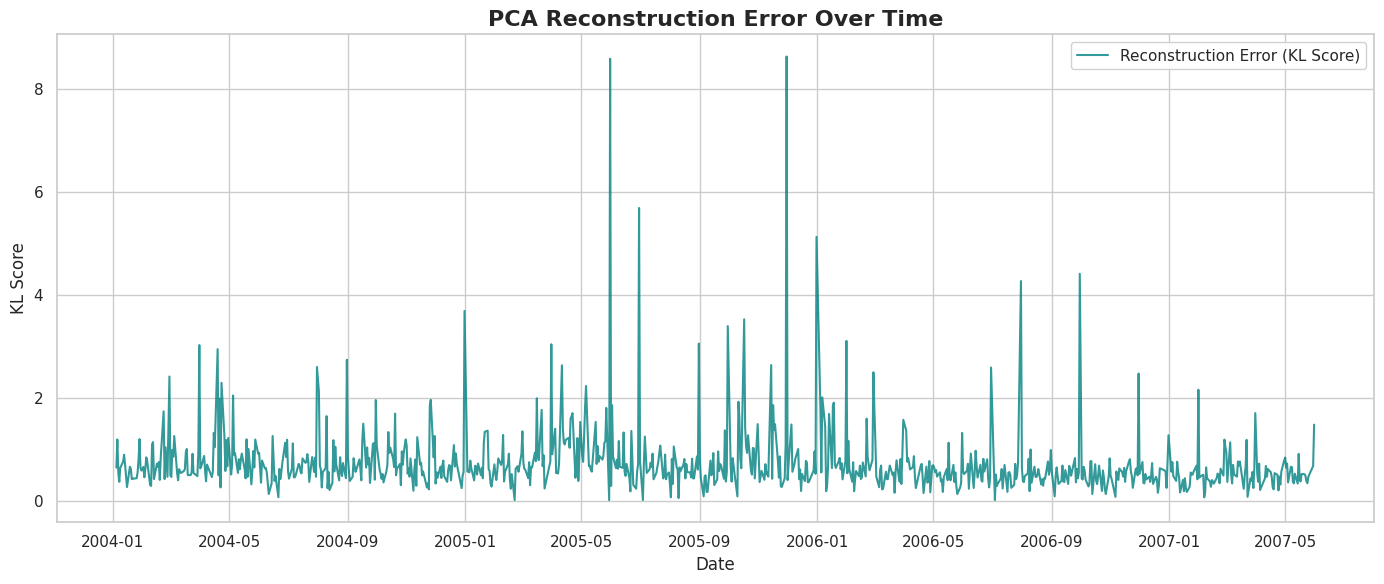

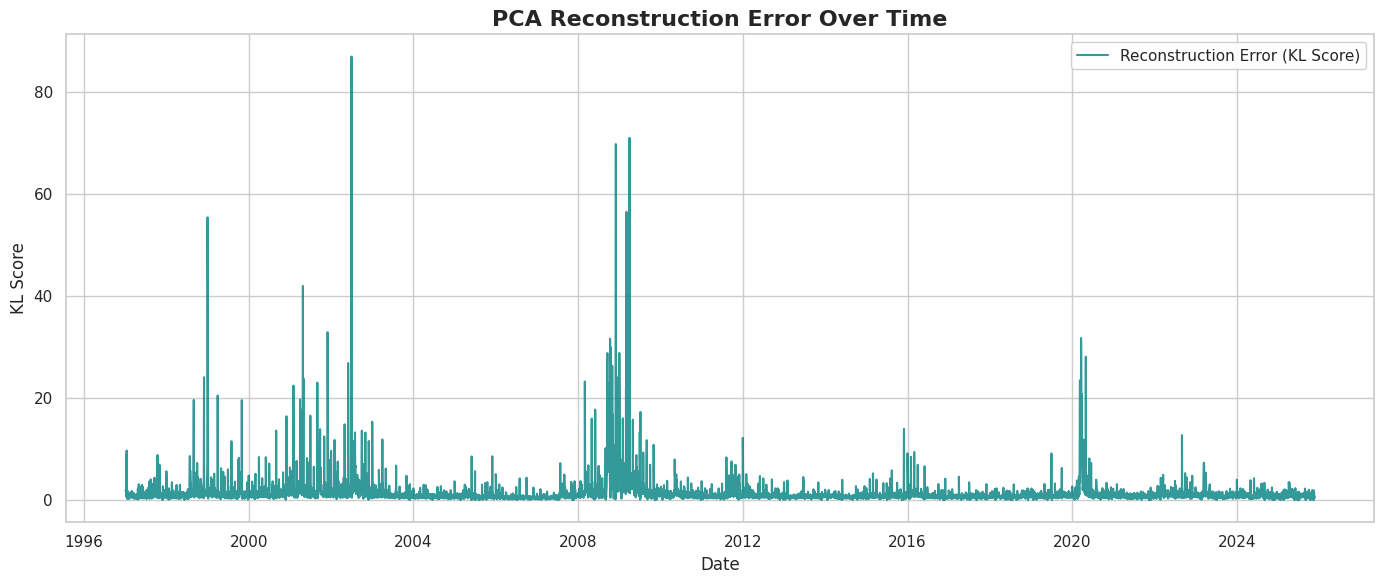

In [13]:
plot_scores(df_kl)
plot_scores(df_kl_full)

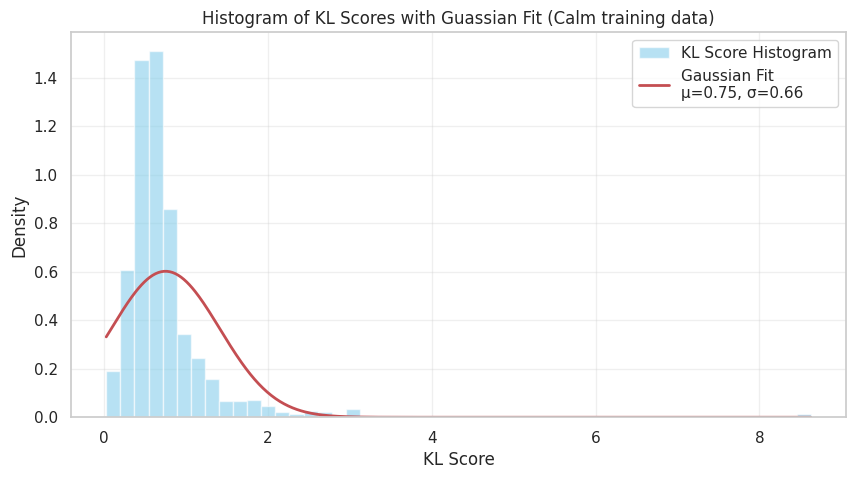

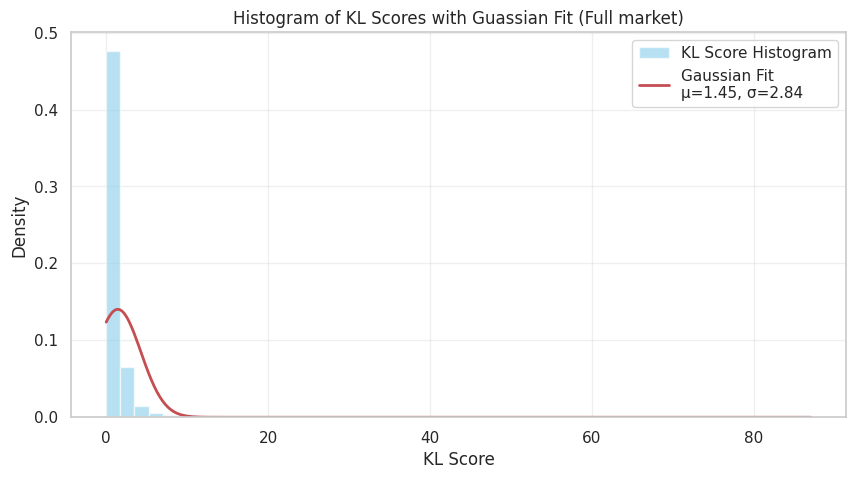

In [14]:
plot_hist(df_kl, 'Histogram of KL Scores with Guassian Fit (Calm training data)')
plot_hist(df_kl_full, 'Histogram of KL Scores with Guassian Fit (Full market)')

The long tail on the second histogram (of the entire data) indicates the high scores of anomaly data (stressed markets).

## Fitting to a Guassian HMM

In [15]:
def run_hmm_pipeline(df_input: pd.DataFrame, config: dict) -> dict:

    def _select_and_process_features(raw_df: pd.DataFrame, config: dict):
        # ... (Feature selection and processing logic remains the same)
        feature_cols = config.get("feature_cols", ["kl_score"])

        if not all(col in raw_df.columns for col in feature_cols):
            raise ValueError(f"feature columns {feature_cols} not found in the input DataFrame.")

        feat_df = raw_df[feature_cols].copy()

        if len(feature_cols) == 1 and config.get("use_log", False):
            feat_df.iloc[:, 0] = np.log1p(feat_df.iloc[:, 0])

        feat_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        feat_df.dropna(inplace=True)

        return feat_df.sort_index()

    def summarize_states(df_results, target_col="kl_score"):
        # ... (Summarization logic remains the same)
        if target_col not in df_results.columns:
             return pd.DataFrame()

        summary = df_results.groupby("state")[target_col].agg(
            Count="count",
            Mean="mean",
            Std="std",
            Min="min",
            Max="max"
        )
        summary = summary.sort_values(by="Mean")
        return summary

    feature_df = _select_and_process_features(df_input, config)

    X_full = feature_df.values
    train_end = pd.to_datetime(config["train_end_date"])
    train_mask = feature_df.index <= train_end
    X_train = X_full[train_mask, :]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_full_scaled = scaler.transform(X_full)

    # NEW LOGIC FOR PERSISTENCE INITIALIZATION

    model_params = {}
    init_params_str = "mc" # Initialize means and covariance, but not transition matrix ('t')

    persistence_factor = config.get("persistence_factor", None)
    N_states = config["n_states"]

    if persistence_factor is not None:
        if 0.0 < persistence_factor < 1.0:
            p = persistence_factor

            q = (1 - p) / (N_states - 1) if N_states > 1 else 0

            A_init = np.full((N_states, N_states), q)

            np.fill_diagonal(A_init, p)

            # Pass the custom matrix to the model constructor
            model_params['transmat_'] = A_init

            init_params_str = "mc" # 'm' for means, 'c' for covariance, but NO 't' for transmat
            print(f"Initialized transition matrix with persistence factor: {p:.2f}")
        else:
            print("Warning: 'persistence_factor' must be between 0.0 and 1.0. Using default HMM initialization.")

    #HMM Model training

    if X_full.shape[1] > 1 and config["covariance_type"] == "diag":
        print("do not use diag parameter when there are more than 1 feature (i.e., multicollinearity)")

    model = GaussianHMM(
        n_components=N_states,
        covariance_type=config["covariance_type"],
        n_iter=config["n_iter"],
        random_state=config["random_state"],
        # CRITICAL: We pass "mc" so the model initializes means/covariances, but not transitions
        init_params=init_params_str
    )

    if 'transmat_' in model_params:
      model.transmat_ = model_params['transmat_']

    if N_states > 0:
        model.startprob_ = np.ones(N_states) / N_states

    print(f"fitting HMM with {config['n_states']} states on data up to {config['train_end_date']}...")
    model.fit(X_train_scaled)


    state_seq = model.predict(X_full_scaled)
    _, posteriors = model.score_samples(X_full_scaled)

    states_df = pd.DataFrame(
        {"state": state_seq},
        index=feature_df.index
    )

    probs_df = pd.DataFrame(
        {f"state_{k}_prob": posteriors[:, k] for k in range(config["n_states"])},
        index=feature_df.index
    )

    df_results = pd.concat([df_input.loc[feature_df.index], states_df, probs_df], axis=1)
    df_summary = summarize_states(df_results)

    return {
        "results": df_results,
        "summary": df_summary,
        "model": model,
        "scaler": scaler,
        "features_processed": feature_df
    }

### HMM Pipeline Driver

#### With training data `df_kl`

In [16]:
HMM_CONFIG = {
    "use_log": True,
    "train_end_date": "2007-12-31",
    "n_states": 3,
    "covariance_type": "diag",
    "n_iter": 500,
    "random_state": 42
}

output = run_hmm_pipeline(df_kl, HMM_CONFIG)

df_kl_hmm_results = output["results"]
df_kl_hmm_model = output["model"]
df_kl_hmm_summary = output["summary"]
df_kl_hmm_feature_series = output["features_processed"]

df_kl_hmm_results

fitting HMM with 3 states on data up to 2007-12-31...


,residual_HIGH_YIELD,residual_CORPORATE,residual_AAA,residual_AA,residual_A,residual_BBB,residual_BB,residual_B,residual_CCC_LOWER,kl_score,state,state_0_prob,state_1_prob,state_2_prob
observation_date,,,,,,,,,,,,,,
2004-01-05,-0.004871,0.004349,-0.002921,0.006717,-0.003434,0.008404,-0.005320,0.009929,-0.001917,0.654005,2,1.845261e-74,1.907071e-14,1.000000
2004-01-06,0.005341,0.005335,0.010091,0.009612,0.000083,0.014328,-0.018500,0.014219,-0.006208,1.199007,2,2.295068e-02,5.100451e-02,0.926045
2004-01-07,-0.005073,0.004920,0.003446,0.003241,0.002992,0.008382,0.007676,-0.003531,0.000564,0.555637,1,4.849011e-03,6.959094e-01,0.299242
2004-01-08,-0.002742,0.005399,0.003049,0.002792,0.002666,0.000236,0.005384,-0.003588,0.000906,0.378546,1,5.262842e-03,8.839723e-01,0.110765
2004-01-09,0.007448,-0.009147,0.001621,-0.008836,-0.007926,-0.002260,-0.002118,-0.003483,-0.000123,0.648835,1,8.676425e-03,9.090576e-01,0.082266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-05-23,-0.001846,0.001326,0.001058,0.000837,-0.009245,0.002196,0.003176,-0.001264,0.000508,0.388668,1,4.573534e-03,9.887644e-01,0.006662
2007-05-24,0.003366,-0.000726,-0.000522,-0.000768,-0.000711,-0.001024,0.004492,-0.007360,0.000820,0.351424,1,7.872935e-03,9.776145e-01,0.014513
2007-05-25,0.003226,-0.000295,0.000075,-0.010146,-0.000172,-0.000730,-0.005823,0.003706,-0.001222,0.475017,1,1.745673e-02,9.303604e-01,0.052183


In [17]:
df_kl_hmm_summary

,Count,Mean,Std,Min,Max
state,,,,,
1,689,0.566284,0.219496,0.024521,1.326737
2,157,1.050747,0.473982,0.024521,2.297887
0,34,3.041273,1.758455,1.356583,8.626756


#### With full data `df_kl_full`

In [18]:
HMM_CONFIG = {
    "use_log": True,
    "train_end_date": "2007-12-31",
    "n_states": 3,
    "covariance_type": "diag",
    "n_iter": 500,
    "random_state": 42
}

# just changed the df input to the full df
output = run_hmm_pipeline(df_kl_full, HMM_CONFIG)

df_kl_full_hmm_results = output["results"]
df_kl_full_hmm_model = output["model"]
df_kl_full_hmm_summary = output["summary"]
df_kl_full_hmm_feature_series = output["features_processed"]

df_kl_full_hmm_results

fitting HMM with 3 states on data up to 2007-12-31...


,residual_HIGH_YIELD,residual_CORPORATE,residual_AAA,residual_AA,residual_A,residual_BBB,residual_BB,residual_B,residual_CCC_LOWER,kl_score,state,state_0_prob,state_1_prob,state_2_prob
observation_date,,,,,,,,,,,,,,
1997-01-03,-0.004126,0.005265,0.047584,0.007377,-0.012535,-0.009034,0.003907,-0.003215,0.001584,1.907282,2,8.167589e-118,2.843999e-22,1.000000
1997-01-06,0.006195,0.000037,-0.050298,-0.000563,0.009517,0.020696,-0.006467,0.004677,-0.003909,2.092681,2,3.010945e-05,2.777573e-02,0.972194
1997-01-07,-0.000418,-0.000294,0.019868,-0.000370,-0.000353,-0.010429,-0.010340,0.009331,-0.000907,0.983083,2,2.721404e-02,1.953226e-02,0.953254
1997-01-08,-0.004047,-0.009015,0.001473,-0.008701,-0.008898,-0.009316,0.004822,-0.001297,0.002954,0.720292,2,4.419907e-02,6.553893e-02,0.890262
1997-01-09,-0.002434,0.013114,0.045796,0.025553,0.015813,0.007781,0.011445,-0.013359,0.000168,2.215249,2,1.616173e-05,4.267257e-01,0.573258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13,-0.007763,0.003647,-0.005032,-0.005363,0.005114,0.000401,0.009357,-0.002704,0.002229,0.592451,2,4.932713e-01,6.502565e-03,0.500226
2025-11-14,-0.002980,-0.008019,0.001047,-0.009205,-0.009226,0.003966,-0.032058,0.036208,-0.006091,1.909270,2,1.055907e-01,1.686145e-02,0.877548
2025-11-17,0.000422,0.006516,-0.003761,0.005873,0.006345,-0.003744,-0.004912,0.004011,-0.000944,0.508097,0,7.484328e-01,2.886951e-03,0.248680


In [19]:
df_kl_full_hmm_summary

,Count,Mean,Std,Min,Max
state,,,,,
0,3438,0.670007,0.269632,0.024521,1.733817
2,3397,1.291898,0.649493,0.024521,4.019276
1,615,6.714371,8.003922,0.024521,87.015183


We can see that the mean of the most volatile state (state 1, i.e., crisis market) reaches much higher in the full set as compared to the train set, indicating much higher residuals.

#### With multivariate PCA data `df_reconstructed`

In [20]:
feature_cols = df_reconstructed.columns

HMM_CONFIG = {
    "use_log": True,
    "feature_cols": feature_cols,
    "train_end_date": "2007-12-31",
    "n_states": 3,
    "covariance_type": "full",
    "n_iter": 500,
    "persistence_factor": 0.99,
    "random_state": 42
}

"""
Note to user: for the reconstructed, try using different states (2-4),
switching between covariance types ("full" and "diag") and persistence factors.
Increasing beyond 500 iterations does not change much.
"""

output = run_hmm_pipeline(df_reconstructed, HMM_CONFIG)

df_pca_hmm_results = output["results"]
df_pca_hmm_model = output["model"]
df_pca_hmm_summary = output["summary"]
df_pca_hmm_feature_series = output["features_processed"]

df_pca_hmm_results

Initialized transition matrix with persistence factor: 0.99
fitting HMM with 3 states on data up to 2007-12-31...


,HIGH_YIELD,CORPORATE,AAA,AA,A,BBB,BB,B,CCC_LOWER,kl_score,state,state_0_prob,state_1_prob,state_2_prob
observation_date,,,,,,,,,,,,,,
1997-01-03,0.034126,0.004735,0.002416,0.002623,0.002535,0.009034,0.016093,0.033215,0.088416,1.907282,2,1.553166e-41,1.114970e-254,1.000000
1997-01-06,0.003805,-0.000037,0.000298,0.000563,0.000483,-0.000696,0.006467,0.005323,-0.006091,2.092681,2,9.614879e-02,8.547495e-06,0.903843
1997-01-07,0.000418,0.000294,0.000132,0.000370,0.000353,0.000429,0.000340,0.000669,0.000907,0.983083,2,1.359163e-03,3.003113e-07,0.998641
1997-01-08,-0.025953,-0.000985,-0.001473,-0.001299,-0.001102,-0.000684,-0.024822,-0.028703,-0.022954,0.720292,2,6.158909e-03,2.792049e-06,0.993838
1997-01-09,0.062434,0.006886,0.004204,0.004447,0.004187,0.012219,0.038555,0.063359,0.129832,2.215249,0,8.980529e-01,3.281664e-04,0.101619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-13,0.077763,0.006353,0.005032,0.005363,0.004886,0.009599,0.060643,0.082704,0.117771,0.592451,2,1.376689e-03,8.287373e-07,0.998622
2025-11-14,-0.017020,-0.001981,-0.001047,-0.000795,-0.000774,-0.003966,-0.007942,-0.016208,-0.043909,1.909270,2,3.841100e-02,3.552847e-06,0.961585
2025-11-17,0.059578,0.003484,0.003761,0.004127,0.003655,0.003744,0.054912,0.065989,0.060944,0.508097,2,1.247163e-03,6.077406e-07,0.998752


In [21]:
df_pca_hmm_summary

,Count,Mean,Std,Min,Max
state,,,,,
2,6022,0.840093,0.399933,0.024521,2.365758
0,1236,2.565714,1.276905,0.344362,7.302969
1,192,13.495509,11.582601,2.560041,87.015183


Note: if you switched to four states, there actually very little captured by the HMM for this state. I got a count of four compared to the range of (200, 6000) between the other states. It seems 3 states is the best

### With some baseline metric
If we have time, run the HMM with some kind of data without using
KL and see how the results in the later sections change

### Plotted State Results

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bond_regimes(start_date,
                      end_date,
                      regimes_df,
                      summary_df,
                      bond_series_name='AAA',
                      bond_data_df=combined_df):

    # ensure indices match
    s_date = pd.to_datetime(start_date)
    e_date = pd.to_datetime(end_date)

    bond_subset = bond_data_df[[bond_series_name]]
    bond_series_renamed = f'{bond_series_name}_orig'
    bond_subset.rename(columns={bond_series_name: bond_series_renamed}, inplace=True)

    plot_df = regimes_df.join(bond_subset, how='inner')

    mask = (plot_df.index >= s_date) & (plot_df.index <= e_date)
    plot_df_filtered = plot_df.loc[mask].copy()

    if plot_df_filtered.empty:
        print(f"no vaid data between {start_date} and {end_date}")
        return

    sorted_state_ids = summary_df.sort_values(by='Mean').index

    # up to 4 incase we choose 4 hidden states
    colors = ['blue', 'orange', 'red', 'purple']
    state_names = ['Calm', 'Stressed', 'Crisis', 'Critical']

    palette = {}
    state_labels = {}
    for i, state_id in enumerate(sorted_state_ids):
        mean_val = summary_df.loc[state_id, 'Mean']
        state_labels[state_id] = f"{state_names[i]} (State {state_id}; Mean KL: {mean_val:.2f})"
        label_str = state_labels[state_id]
        palette[label_str] = colors[min(i, len(colors)-1)]

    plot_df_filtered['state_label'] = plot_df_filtered['state'].map(state_labels)

    plt.figure(figsize=(16, 8))

    sns.scatterplot(
        data=plot_df_filtered,
        x=plot_df_filtered.index,
        y=bond_series_renamed,
        hue='state_label',
        palette=palette,
        s=15,
        alpha=0.8
    )

    plt.title(f'{bond_series_renamed} Bond Prices in HMM States ({start_date} to {end_date})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{bond_series_renamed} Price', fontsize=12)
    plt.legend(title='HMM State', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### With full data `df_kl_full`

/tmp/ipython-input-1950976801.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_subset.rename(columns={bond_series_name: bond_series_renamed}, inplace=True)


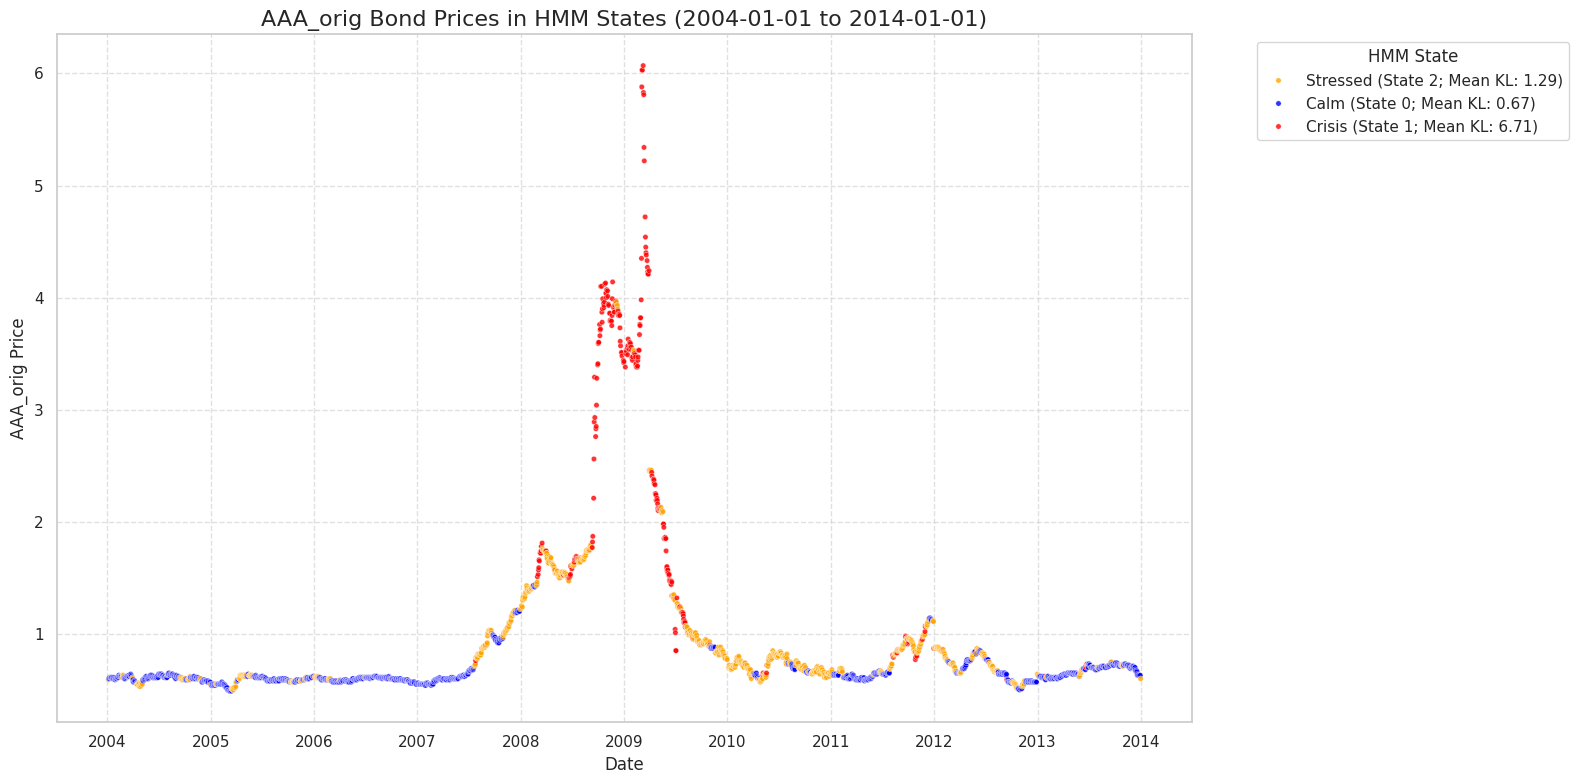

In [23]:
plot_bond_regimes('2004-01-01',
                  '2014-01-01',
                  df_kl_full_hmm_results,
                  df_kl_full_hmm_summary)

#### With multivariate PCA data `df_reconstructed`

/tmp/ipython-input-1950976801.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_subset.rename(columns={bond_series_name: bond_series_renamed}, inplace=True)


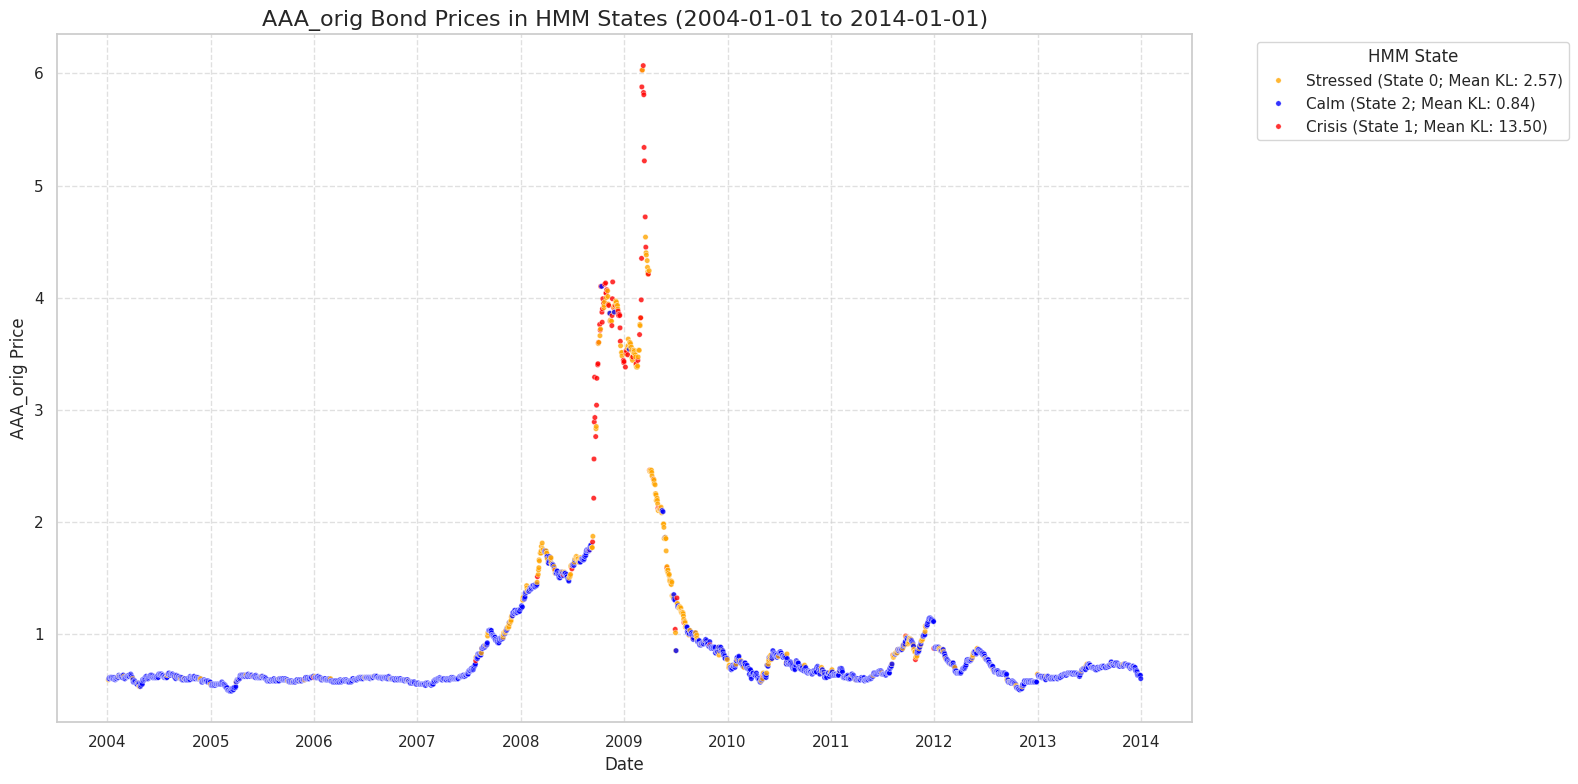

In [24]:
plot_bond_regimes('2004-01-01',
                  '2014-01-01',
                  df_pca_hmm_results,
                  df_pca_hmm_summary)

### State KL Score Distributions

In [25]:
def plot_hmm_states_histogram(df: pd.DataFrame,
                              summary_df: pd.DataFrame,
                              target_col: str = "kl_score",
                              state_col: str = "state",
                              state_names: list = ['Calm', 'Stressed', 'Crisis', 'Critical'],
                              colors: list = ['blue', 'orange', 'red', 'purple'],
                              x_max_lim=None):

    sorted_state_ids = summary_df.sort_values(by='Mean').index
    print(sorted_state_ids)
    palette = {}
    state_labels = {}

    for i, state_id in enumerate(sorted_state_ids):
        mean_val = summary_df.loc[state_id, 'Mean']
        state_labels[state_id] = f"{state_names[i]} (State {state_id}; Mean KL: {mean_val:.2f})"
        label_str = state_labels[state_id]
        palette[label_str] = colors[min(i, len(colors)-1)]

    df_plot = df.copy()
    df_plot['state_label'] = df_plot[state_col].map(state_labels)

    plt.figure(figsize=(12, 6))

    sns.histplot(
        data=df_plot,
        x=target_col,
        hue='state_label',
        kde=True,
        element="step",
        stat="density",
        common_norm=False,
        palette=palette
    )

    hue_order = [state_labels[i] for i in sorted_state_ids]
    plt.legend(title='HMM State', labels=hue_order)

    plt.title(f"Distribution of {target_col} by HMM State")
    plt.xlabel(f"{target_col} value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, x_max_lim)
    plt.show()

#### With full data `df_kl_full`

Index([0, 2, 1], dtype='int64', name='state')


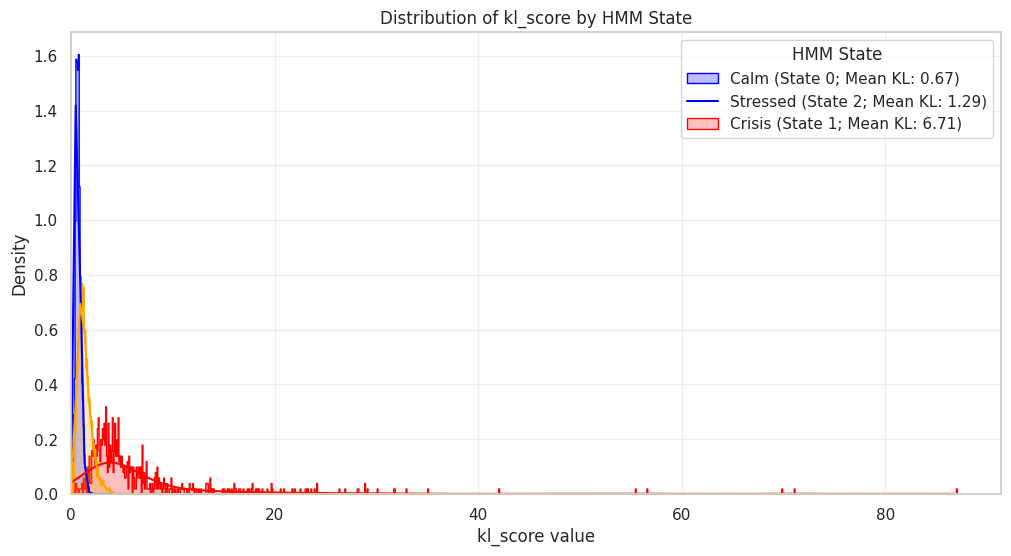

In [26]:
plot_hmm_states_histogram(
    df=df_kl_full_hmm_results,
    summary_df=df_kl_full_hmm_summary,
    target_col="kl_score"
)

The huge tail indicates the range of these outliers on the Crisis state. Lets zoom in to a max KL of 20.

Index([0, 2, 1], dtype='int64', name='state')


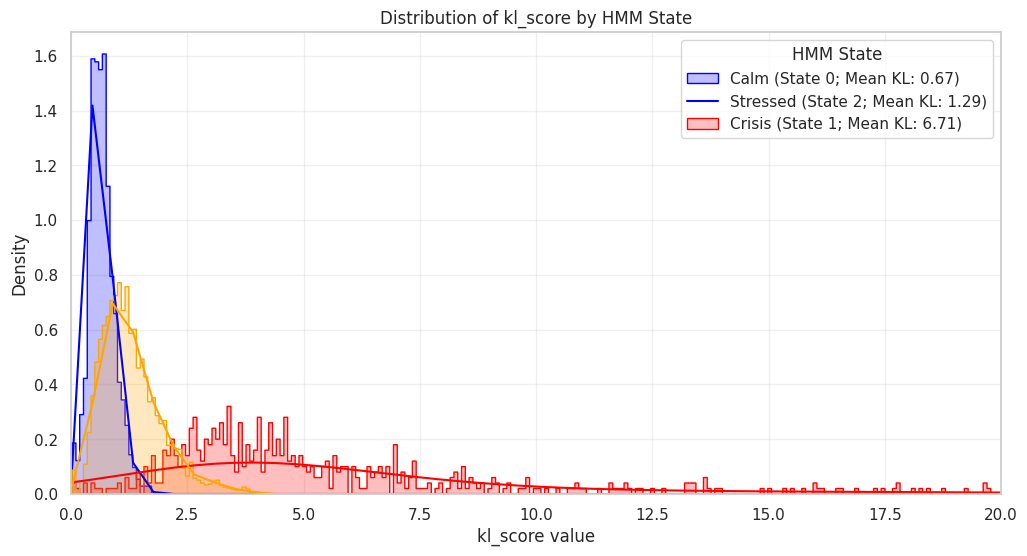

In [27]:
plot_hmm_states_histogram(
    df=df_kl_full_hmm_results,
    summary_df=df_kl_full_hmm_summary,
    target_col="kl_score",
    x_max_lim=20
)

#### With multivariate PCA data `df_reconstructed`

Index([2, 0, 1], dtype='int64', name='state')


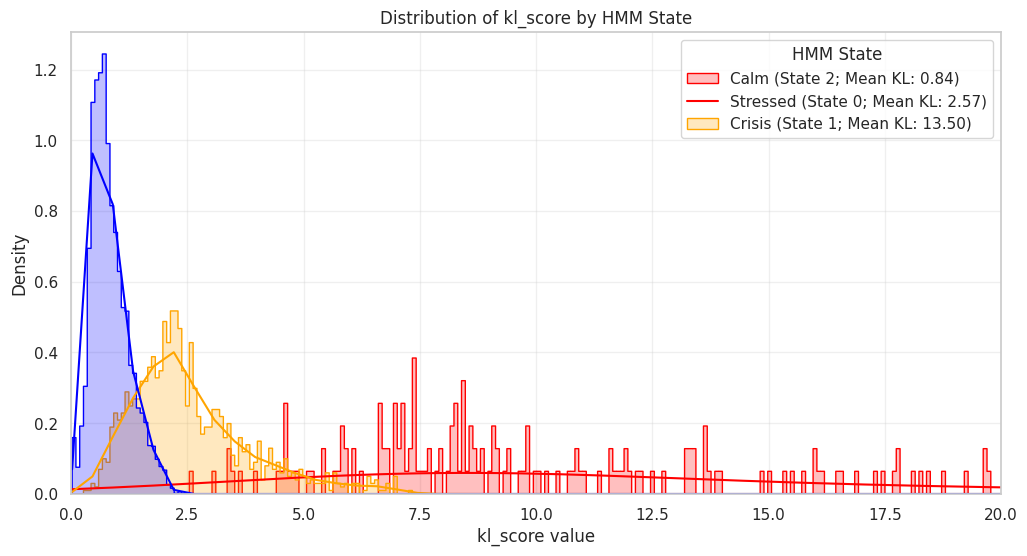

In [28]:
# TODO: fix function state auto-labeling in legend. Actual graph colors are fine though.
plot_hmm_states_histogram(
    df=df_pca_hmm_results,
    summary_df=df_pca_hmm_summary,
    target_col="kl_score",
    x_max_lim=20
)

The mean of crisis for KL score stretches much further when using PCA as direct HMM input.

### Model Transition Matrix and Persistence

We are looking for high persistence in the calmer states, indicating that the model is likely to stay in the state of its previous time step on the next timestep. These numbers will decrease in the critical/crisis states as the residual outliers become more unpredictable.

In [29]:
def print_matrix(matrix, title):
    print(f"\n{title}:")
    print(np.round(matrix, 4))

print("--- Details for Full KL Score Data ---")

trans_mat = df_kl_full_hmm_model.transmat_
print_matrix(trans_mat, "HMM Transition Matrix (Probability of staying/switching)")

persistence = np.diag(trans_mat)
for i, p in enumerate(persistence):
    print(f"State {i} Persistence: {p:.2%}")

print()
print("--- Details for PCA (Multivariate) HMM Trained Data ---")

trans_mat = df_pca_hmm_model.transmat_
print_matrix(trans_mat, "HMM Transition Matrix (Probability of staying/switching)")

persistence = np.diag(trans_mat)
for i, p in enumerate(persistence):
    print(f"State {i} Persistence: {p:.2%}")


--- Details for Full KL Score Data ---

HMM Transition Matrix (Probability of staying/switching):
[[0.9063 0.0119 0.0818]
 [0.0203 0.6528 0.3269]
 [0.0761 0.0745 0.8494]]
State 0 Persistence: 90.63%
State 1 Persistence: 65.28%
State 2 Persistence: 84.94%

--- Details for PCA (Multivariate) HMM Trained Data ---

HMM Transition Matrix (Probability of staying/switching):
[[0.5293 0.0681 0.4026]
 [0.6492 0.1273 0.2235]
 [0.1035 0.0093 0.8872]]
State 0 Persistence: 52.93%
State 1 Persistence: 12.73%
State 2 Persistence: 88.72%


We also want somewhat high persistance in states, especially the calm state. The other two may be a little lower as they tend to fluctuate quickly.

#Trading Game

In [30]:
# Frank path: '/content/drive/MyDrive/Classes/7 Fall 2025/DS 340/DS 340 Project/tradingdata'
# Jesse path: '/content/drive/MyDrive/S&P'
folder_path = '/content/drive/MyDrive/S&P'

In [31]:
spx_folder_path = '/content/drive/MyDrive/S&P'

# Find the first CSV in that folder
spx_files = [f for f in os.listdir(spx_folder_path) if f.endswith('.csv')]
if len(spx_files) == 0:
    raise FileNotFoundError("No CSV files found in /content/drive/MyDrive/S&P")

spx_path = os.path.join(spx_folder_path, spx_files[0])
print("Using file:", spx_path)

spx_df = pd.read_csv(spx_path)

# Convert the 'Date' column to datetime and set it as the index
spx_df['Date'] = pd.to_datetime(spx_df['Date'], format='%m/%d/%Y', errors='coerce')
spx_df = spx_df.set_index('Date').sort_index()

# Convert 'Price' and other relevant columns to numeric, handling commas and percentages
for col in ['Price', 'Open', 'High', 'Low']:
    spx_df[col] = spx_df[col].str.replace(',', '', regex=False).astype(float)

spx_df['Change %'] = spx_df['Change %'].str.replace('%', '', regex=False).astype(float) / 100

# Drop 'Vol.' column if it contains NaN or is not relevant (assuming it's mostly NaN from the output)
if 'Vol.' in spx_df.columns:
    spx_df = spx_df.drop(columns=['Vol.'])

print(spx_df)

Using file: /content/drive/MyDrive/S&P/S&P 500 Historical Data.csv
              Price     Open     High      Low  Change %
Date                                                    
2008-11-25   857.40   853.40   868.90   835.00    0.0066
2008-11-26   887.70   852.90   887.70   841.40    0.0353
2008-11-28   896.20   886.90   896.20   881.20    0.0096
2008-12-01   816.20   888.60   888.60   815.70   -0.0893
2008-12-02   848.80   817.90   850.50   817.90    0.0399
...             ...      ...      ...      ...       ...
2025-11-19  6642.16  6625.84  6689.75  6603.50    0.0038
2025-11-20  6538.76  6737.93  6770.35  6534.05   -0.0156
2025-11-21  6602.99  6555.77  6660.05  6521.92    0.0098
2025-11-24  6705.12  6636.54  6715.75  6630.70    0.0155
2025-11-25  6765.88  6697.03  6776.40  6659.98    0.0091

[4277 rows x 5 columns]


In [32]:
spx_df.columns = spx_df.columns.str.strip().str.lower()
spx_deltas = spx_df[['price']]


In [33]:
spx_prices = spx_df['price'].astype(float)

spx_returns = spx_prices.pct_change().dropna()
spx_returns.name = 'SPX_return'

spx_returns


,SPX_return
Date,
2008-11-26,0.035339
2008-11-28,0.009575
2008-12-01,-0.089266
2008-12-02,0.039941
2008-12-03,0.025801
...,...
2025-11-19,0.003754
2025-11-20,-0.015567
2025-11-21,0.009823


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bond_and_spx_regimes(start_date,
                              end_date,
                              bond_series_name='AAA',
                              regimes_df=df_kl_full_hmm_results,
                              bond_data_df=combined_df,
                              spx_data_df=spx_df,
                              summary_df=df_kl_full_hmm_summary):

    s_date = pd.to_datetime(start_date)
    e_date = pd.to_datetime(end_date)

    bond_subset = bond_data_df[[bond_series_name]]

    new_bond_series_name = f"{bond_series_name}_orig"
    bond_subset.rename(columns={bond_series_name: new_bond_series_name}, inplace=True)

    spx_subset = spx_data_df[['price']].rename(columns={'price': 'SPX_Price'})

    plot_df = regimes_df.join(bond_subset, how='inner')
    plot_df = plot_df.join(spx_subset, how='inner')

    mask = (plot_df.index >= s_date) & (plot_df.index <= e_date)
    plot_df_filtered = plot_df.loc[mask].copy()

    if plot_df_filtered.empty:
        print(f"No data found between {start_date} and {end_date}.")
        return

    state_labels = {}
    for state_id in summary_df.index:
        mean_val = summary_df.loc[state_id, 'Mean']
        state_labels[state_id] = f"State {state_id} (Mean KL: {mean_val:.2f})"

    plot_df_filtered['state_label'] = plot_df_filtered['state'].map(state_labels)

    sorted_state_ids = summary_df.sort_values(by='Mean').index

    colors = ['blue', 'orange', 'red', 'purple']
    palette = {}

    for i, state_id in enumerate(sorted_state_ids):
        label_str = state_labels[state_id]
        palette[label_str] = colors[min(i, len(colors)-1)]

    # Plots
    fig, ax1 = plt.subplots(figsize=(16, 8))
    sns.set_theme(style="whitegrid")

    sns.scatterplot(
        data=plot_df_filtered,
        x=plot_df_filtered.index,
        y=new_bond_series_name,
        hue='state_label',
        palette=palette,
        s=20,
        alpha=0.8,
        ax=ax1,
        legend='full'
    )

    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel(f'{bond_series_name} Index (Original)', fontsize=12, color='teal')
    ax1.tick_params(axis='y', labelcolor='teal')

    # Create a secondary y-axis for S&P 500 prices
    ax2 = ax1.twinx()
    sns.lineplot(
        data=plot_df_filtered,
        x=plot_df_filtered.index,
        y='SPX_Price',
        color='darkgray',
        linewidth=1.5,
        alpha=0.7,
        ax=ax2,
        label='S&P 500 Price'
    )

    ax2.set_ylabel('S&P 500 Price', fontsize=12, color='darkgray')
    ax2.tick_params(axis='y', labelcolor='darkgray')
    ax2.legend(loc='upper right')

    fig.autofmt_xdate()

    plt.title(f'{bond_series_name} Index (HMM Regimes) and S&P 500 Prices ({start_date} to {end_date})', fontsize=16)
    ax1.legend(title='HMM State', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

### AAA Bonds Benchmarked against S&P 500 Prices during COVID-19

#### Using KL Full Model

/tmp/ipython-input-3998771330.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_subset.rename(columns={bond_series_name: new_bond_series_name}, inplace=True)


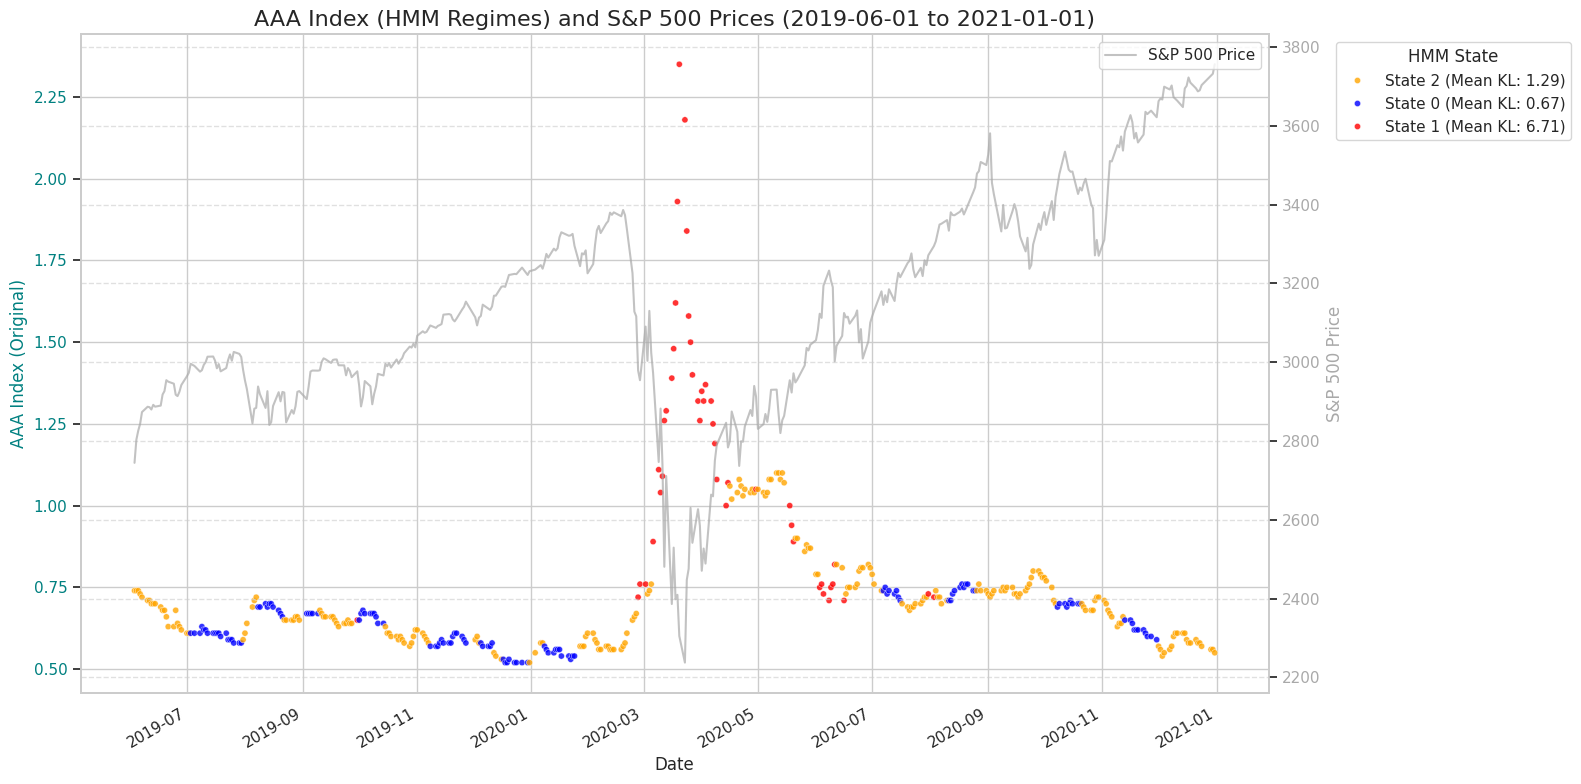

In [35]:
# Call the new plotting function
plot_bond_and_spx_regimes(start_date='2019-06-01', end_date='2021-01-01')

#### Using Multivariate PCA Model

/tmp/ipython-input-3998771330.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_subset.rename(columns={bond_series_name: new_bond_series_name}, inplace=True)


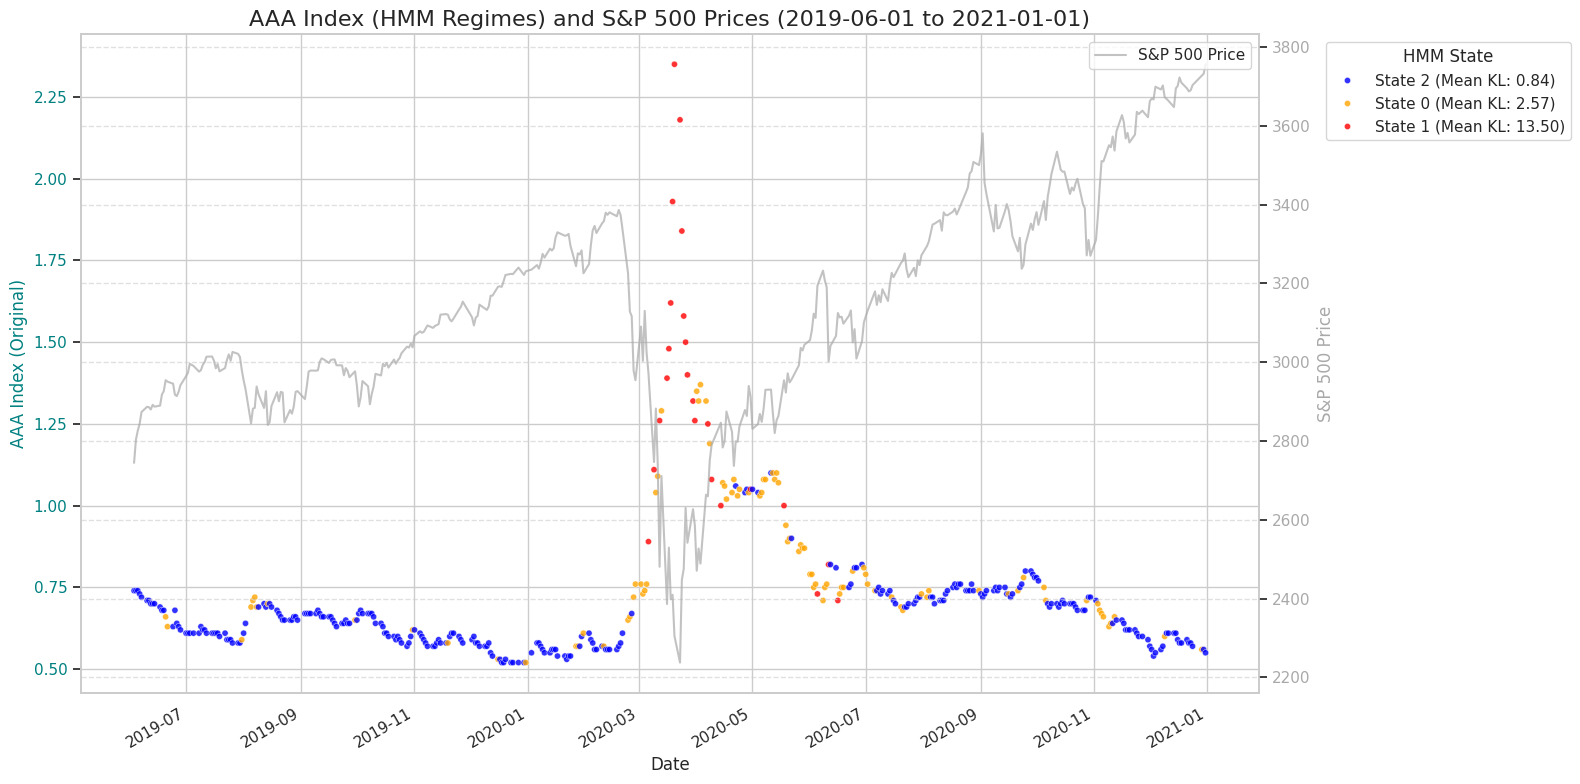

In [36]:
plot_bond_and_spx_regimes(start_date='2019-06-01', end_date='2021-01-01', regimes_df=df_pca_hmm_results, summary_df=df_pca_hmm_summary)

In [37]:
import numpy as np
import pandas as pd

def add_state_age(states_df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame with a 'state' column, add 'state_age':
    number of consecutive days spent in the current state so far.
    """
    df = states_df.copy()
    ages = np.zeros(len(df), dtype=int)

    prev_state = None
    run = 0
    for i, s in enumerate(df['state'].values):
        if i == 0 or s != prev_state:
            run = 1
        else:
            run += 1
        ages[i] = run
        prev_state = s

    df['state_age'] = ages
    return df

def unstable_run_stats(states_df: pd.DataFrame, unstable_state: int = 0):
    """
    Compute distribution stats of continuous runs of 'unstable_state'.
    Returns dict with mean, median, 75th percentile, etc.
    """
    runs = []
    run = 0
    for s in states_df['state'].values:
        if s == unstable_state:
            run += 1
        else:
            if run > 0:
                runs.append(run)
                run = 0
    if run > 0:
        runs.append(run)

    runs = np.array(runs, dtype=float)
    if len(runs) == 0:
        # If no unstable runs, return appropriate stats or raise an error
        # For now, let's return stats that indicate no runs were found
        return {
            "mean":   0.0,
            "median": 0.0,
            "p75":    0.0,
            "p90":    0.0,
            "count":  0
        }

    stats = {
        "mean":   runs.mean(),
        "median": np.median(runs),
        "p75":    np.percentile(runs, 75),
        "p90":    np.percentile(runs, 90),
        "count":  len(runs)
    }
    return stats

# Apply to your regimes DataFrame
df_regimes_with_age = add_state_age(df_kl_full_hmm_results)   # adds 'state_age'
unstable_state = 0  # change if your 'unstable' regime is a different label
unstable_stats = unstable_run_stats(df_regimes_with_age, unstable_state)

print("Unstable run stats:", unstable_stats)


Unstable run stats: {'mean': np.float64(18.19047619047619), 'median': np.float64(12.0), 'p75': np.float64(21.0), 'p90': np.float64(40.0), 'count': 189}


In [38]:
import plotly.graph_objects as go
import pandas as pd

def backtest_spx_duration_aware_strategy(spx_prices: pd.Series,
                                         spx_returns: pd.Series,
                                         df_regimes: pd.DataFrame,
                                         initial_capital: float = 10_000.0,
                                         unstable_state: int = 0,
                                         crisis_state: int = 1,
                                         duration_mult: float = 1.5):

    # Ensure state_age exists
    if 'state_age' not in df_regimes.columns:
        df_reg = add_state_age(df_regimes)
    else:
        df_reg = df_regimes.copy()

    # Compute mean unstable duration
    stats_unstable = unstable_run_stats(df_reg, unstable_state=unstable_state)
    mean_unstable = stats_unstable["mean"]

    # Align data
    data = pd.DataFrame({"SPX": spx_prices}).join(
        spx_returns.rename("spx_ret"), how="inner"
    )
    data = data.join(df_reg[["state", "state_age"]], how="inner")
    data = data.dropna()

    # Build raw position signal
    pos_signal = []

    for _, row in data.iterrows():
        st = row["state"]
        age = row["state_age"]

        # Normal → fully long
        if (st != unstable_state) and (st != crisis_state):
            pos = 1.0

        # Crisis → flat
        elif st == crisis_state:
            pos = 0.0

        # Unstable → depends on duration
        else:
            if age <= mean_unstable * duration_mult:
                pos = 0.0   # early/mid unstable → defensive
            else:
                pos = 0.5   # long unstable → cautiously long

        pos_signal.append(pos)

    data["position_signal"] = pos_signal

    # Apply 1-day lag
    data["position"] = data["position_signal"].shift(1).fillna(0.0)

    # Compute returns
    data["strategy_ret"] = data["position"] * data["spx_ret"]
    data["bh_ret"] = data["spx_ret"]

    # Equity curves
    data["strategy_equity"] = initial_capital * (1 + data["strategy_ret"]).cumprod()
    data["bh_equity"]       = initial_capital * (1 + data["bh_ret"]).cumprod()

    final_strategy = data["strategy_equity"].iloc[-1]
    final_bh       = data["bh_equity"].iloc[-1]

    print("===== Duration-aware Strategy Results =====")
    print(f"Initial capital: ${initial_capital:,.2f}")
    print(f"Final capital (Strategy): ${final_strategy:,.2f}")
    print(f"Final capital (Buy & Hold): ${final_bh:,.2f}")

    # ---------- PLOTLY VERSION ----------
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=data.index,
        y=data["strategy_equity"],
        mode='lines',
        name="Duration-aware Strategy",
        line=dict(color='blue', width=2)
    ))

    fig.add_trace(go.Scatter(
        x=data.index,
        y=data["bh_equity"],
        mode='lines',
        name="Buy & Hold",
        line=dict(color='gray', width=2, dash='dash')
    ))

    fig.update_layout(
        title="S&P 500 Duration-aware Regime Strategy vs Buy & Hold",
        xaxis_title="Date",
        yaxis_title="Portfolio Value ($)",
        template="plotly_white",
        height=600,
        width=1000,
        legend=dict(x=0.02, y=0.98)
    )

    fig.show()
    # ---------- END PLOTLY VERSION ----------

    return data, stats_unstable


In [39]:
spx_prices = spx_df['price'].astype(float)
spx_returns = spx_prices.pct_change().dropna()

results_duration, unstable_stats = backtest_spx_duration_aware_strategy(
    spx_prices=spx_prices,
    spx_returns=spx_returns,
    df_regimes=df_regimes_with_age,   # or df_regimes if you want it to compute age
    initial_capital=10_000.0,
    unstable_state=0,                 # change to your actual unstable label
    crisis_state=1,                   # change to your actual crisis label
    duration_mult=1.5                 # how "longer than normal" counts
)
print("Unstable stats used:", unstable_stats)


===== Duration-aware Strategy Results =====
Initial capital: $10,000.00
Final capital (Strategy): $25,466.18
Final capital (Buy & Hold): $66,489.15


Unstable stats used: {'mean': np.float64(18.19047619047619), 'median': np.float64(12.0), 'p75': np.float64(21.0), 'p90': np.float64(40.0), 'count': 189}


#Rolling KL window

In [40]:
import numpy as np
import pandas as pd

def compute_rolling_kl_scores(df_deltas: pd.DataFrame,
                              window: int = 500,
                              target_var_explained: float = 0.95):
    """
    Rolling KL score:
      For each day t >= window:
        - Use previous `window` days as the 'calm' window
        - Compute mean, covariance, eigen-decomp
        - Choose m s.t. cumulative variance >= target_var_explained
        - Compute residual norm for day t, normalized by discarded eigenvalues
    """
    X = df_deltas.values
    dates = df_deltas.index
    n_obs, n_dim = X.shape

    residuals_list = []
    scores_list = []
    out_dates = []

    for t in range(window, n_obs):
        # training window [t-window, t)
        X_win = X[t-window:t, :]
        mu_win = X_win.mean(axis=0)

        Xc = X_win - mu_win
        C = Xc.T @ Xc / (Xc.shape[0] - 1)

        eigvals, eigvecs = np.linalg.eigh(C)
        idx = eigvals.argsort()[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        cumvar = np.cumsum(eigvals)
        total_var = cumvar[-1]
        var_ratio = cumvar / total_var

        m = np.searchsorted(var_ratio, target_var_explained) + 1
        m = min(m, eigvals.shape[0])

        # residual for current day t
        v_t = X[t, :]
        w_t = v_t - mu_win
        Phi_m = eigvecs[:, :m]
        Z = w_t @ Phi_m

        v_hat_t = mu_win + Z @ Phi_m.T
        r_t = v_t - v_hat_t

        discarded_var = eigvals[m:].sum() if m < eigvals.shape[0] else 1.0
        if discarded_var <= 0:
            discarded_var = 1.0

        residual_norm = np.linalg.norm(r_t)
        score_t = residual_norm / np.sqrt(discarded_var)

        residuals_list.append(r_t)
        scores_list.append(score_t)
        out_dates.append(dates[t])

    residuals_arr = np.vstack(residuals_list)
    scores_arr = np.array(scores_list)

    df_kl_roll = pd.DataFrame(
        residuals_arr,
        index=pd.Index(out_dates, name=df_deltas.index.name),
        columns=[f"residual_{c}" for c in df_deltas.columns]
    )
    df_kl_roll["kl_score_roll"] = scores_arr

    return df_kl_roll

df_kl_roll = compute_rolling_kl_scores(df_deltas)


In [41]:
def prepare_hmm_features_from_roll(df_kl_roll: pd.DataFrame, use_log: bool = True) -> pd.Series:
    scores = df_kl_roll["kl_score_roll"].copy()
    scores = scores.replace([np.inf, -np.inf], np.nan).dropna()
    if use_log:
        features = np.log1p(scores)
    else:
        features = scores
    features.name = "hmm_feature_roll"
    return features

def fit_hmm_on_feature_series(feature_series: pd.Series,
                              train_end: str,
                              n_states: int,
                              random_state: int,
                              covariance_type: str = "full",
                              n_iter: int = 500
                              ):
    """
    Fits a GaussianHMM model on a given feature series.

    Args:
        feature_series (pd.Series): The input feature series for HMM.
        train_end (str): The end date for the training period.
        n_states (int): The number of hidden states for the HMM.
        random_state (int): Random state for reproducibility.
        covariance_type (str): The covariance type for the HMM (e.g., 'full', 'diag').
        n_iter (int): The maximum number of iterations to perform.

    Returns:
        tuple: A tuple containing the fitted HMM model, scaler, states DataFrame, and probabilities DataFrame.
    """
    train_end_dt = pd.to_datetime(train_end)
    train_mask = feature_series.index <= train_end_dt

    X_train = feature_series.loc[train_mask].values.reshape(-1, 1)
    X_full = feature_series.values.reshape(-1, 1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_full_scaled = scaler.transform(X_full)

    model = GaussianHMM(
        n_components=n_states,
        covariance_type=covariance_type,
        n_iter=n_iter,
        random_state=random_state
    )

    print(f"Fitting HMM with {n_states} states on data up to {train_end}...")
    model.fit(X_train_scaled)

    state_seq = model.predict(X_full_scaled)
    _, posteriors = model.score_samples(X_full_scaled)

    states_df = pd.DataFrame(
        {"state": state_seq},
        index=feature_series.index
    )

    probs_df = pd.DataFrame(
        {f"state_{k}_prob": posteriors[:, k] for k in range(n_states)},
        index=feature_series.index
    )

    return model, scaler, states_df, probs_df

feature_series_roll = prepare_hmm_features_from_roll(df_kl_roll, use_log=True)

model_roll, scaler_roll, states_df_roll, probs_df_roll = fit_hmm_on_feature_series(
    feature_series_roll,
    train_end="2007-12-31",  # keep same train cutoff, or move it if you want
    n_states=3,
    random_state=42,
)


Fitting HMM with 3 states on data up to 2007-12-31...


In [42]:
df_regimes_roll = pd.concat(
    [df_kl_roll[["kl_score_roll"]], states_df_roll, probs_df_roll],
    axis=1
)
df_regimes_roll


,kl_score_roll,state,state_0_prob,state_1_prob,state_2_prob
observation_date,,,,,
1998-12-17,0.712532,2,5.086190e-13,1.450231e-42,1.000000
1998-12-18,0.530676,2,9.709130e-02,3.201246e-03,0.899707
1998-12-21,0.500477,2,2.492987e-01,7.360626e-03,0.743341
1998-12-22,0.598797,2,5.591584e-01,1.827736e-02,0.422564
1998-12-23,0.902143,0,8.797942e-01,5.941310e-02,0.060793
...,...,...,...,...,...
2025-11-13,0.566358,0,7.927994e-01,5.652936e-02,0.150671
2025-11-14,1.779546,0,6.526062e-01,3.473792e-01,0.000015
2025-11-17,0.477781,0,6.286140e-01,4.293272e-02,0.328453


In [43]:
spx_prices = spx_df["price"].astype(float) # Changed 'price' to 'Price'
spx_returns = spx_prices.pct_change().dropna()

results_duration_roll, unstable_stats_roll = backtest_spx_duration_aware_strategy(
    spx_prices=spx_prices,
    spx_returns=spx_returns,
    df_regimes=df_regimes_roll,   # <— rolling KL-based regimes
    initial_capital=10_000.0,
    unstable_state=0,             # adjust if your labels differ
    crisis_state=1,
    duration_mult=1.5
)

print("Unstable run stats (rolling regimes):", unstable_stats_roll)


===== Duration-aware Strategy Results =====
Initial capital: $10,000.00
Final capital (Strategy): $22,582.56
Final capital (Buy & Hold): $66,489.15


Unstable run stats (rolling regimes): {'mean': np.float64(12.570446735395189), 'median': np.float64(8.0), 'p75': np.float64(17.0), 'p90': np.float64(28.0), 'count': 291}
